<a href="https://colab.research.google.com/github/braunito/my_study-analytics/blob/main/2021-11_KniebeugenAuswertung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack
from scipy import signal


#================================================================
# Daten einlesen und extrahieren
#================================================================
import os
#os.chdir('D:\00-Daten\01-DHGS\02-Forschung\Code\COP-Sway')
#data=pd.read_csv('VP004_105kg.txt', encoding = 'utf8', sep='\t',decimal=',',skiprows=0) 
#y=np.array(data.loc[:,'y'])
#t=np.array(data.loc[:,'t'])



#plt.plot(y)

#b, a = signal.butter(2, 1/50,'low')

#y_filtered=signal.filtfilt(b,a,y)

#plt.plot(y_filtered,'blue')

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path= '/content/drive/MyDrive/data/2021-11-squats'
file_list = sorted([f for f in os.listdir(path) if f.endswith('.txt')])
file_frames=[pd.read_csv( path+ '/' + f,skiprows=0,sep='\t',decimal=',') for f in file_list]




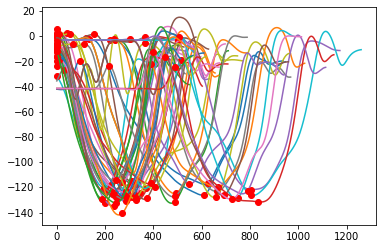

In [60]:
for i in range(0,len(file_frames)):
    data=file_frames[i]
    #zz=data['Hip, left Flexion/Extension']
    zz=data['Knee, left Flexion/Extension']
    b, a = signal.butter(2, 1/50,'low')
    zz=zz.drop([0,1])
    zz_filt=signal.filtfilt(b,a,zz)
    zz_filt_dif=np.diff(zz_filt)

    t1= zz.idxmin()
 
    zz_f_d_f=np.flip(zz_filt_dif[0:t1-20])
    res = next((x for x, val in enumerate(zz_f_d_f) if val > 0),0)

    if res==0:
      t0=0
    else:
      t0=t1-res-20

    plt.plot(zz_filt)
    plt.plot(t0,zz_filt[t0],'-ro')
    plt.plot(t1,zz_filt[t1],'-ro')
    
    b, a = signal.butter(2, 5/50,'low')
    ankle=signal.filtfilt(b,a,data['Ankle, left Dorsal-/Plantar-Flexion'])
    knee=signal.filtfilt(b,a,data['Knee, left Flexion/Extension'])
    hip=signal.filtfilt(b,a,data['Hip, left Flexion/Extension'])

    AAX = resample_by_interpolation(ankle[t0:t1], len(ankle[t0:t1]),101)
    KAX = resample_by_interpolation(knee[t0:t1], len(knee[t0:t1]),101)*(-1)
    HAX = resample_by_interpolation(hip[t0:t1], len(hip[t0:t1]),101)


    df_ex=pd.DataFrame(columns=['AAX','KAX','HAX'])
    df_ex['AAX']=AAX
    df_ex['KAX']=KAX
    df_ex['HAX']=HAX
    
    df_ex.to_csv(path+'/export/mod_'+file_list[i]+'.csv',decimal='.',sep=';')
